In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
lst_class = Base.classes.keys()
lst_class

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# get table and colum names
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print("Table name: %s" % table_name)
    for column in inspector.get_columns(table_name):
        print("Column: %s" % column)

Table name: measurement
Column: {'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
Column: {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Table name: station
Column: {'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
Column: {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_k

In [10]:
# Start a session to query the database
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
def plot_precipiation(session, begin_date, end_date, fname, title):
    # retrieve data the last 12 months of precipitation data 
    print(f'Drawing plot for dates from {begin_date} to {end_date} into file name "{fname}"')
    results_gb = session.query(Measurement.date, func.round(func.sum(Measurement.prcp),2))\
        .filter(Measurement.date >= begin_date).filter(Measurement.date < end_date).group_by(Measurement.date).all()
    dates_gb = [result[0] for result in results_gb[:]]
    precips_gb = [result[1] for result in results_gb[:]]
    precips_max_gb = 1
    if len(precips_gb) == 0:
        print(f'No precipitation data found between {begin_date} to {end_date}')
        title = title + " - NO DATA"
    else:
        precips_max_gb = round(max(precips_gb), 0) + 1
    
    # plot the results
    fig_gb, ax_gb = plt.subplots()
    y_pos_gb = np.arange(precips_max_gb)
    ax_gb.bar(dates_gb, precips_gb)

    ax_gb.set_xlabel("Date")
    ax_gb.set_ylabel("Precipitation")
    ax_gb.set_yticks(y_pos_gb)
    ax_gb.set_title(title)
    fig_gb.tight_layout()
    plt.show()
    fig_gb.savefig(fname, dpi=300)

Drawing plot for dates from 2019-02-24 to 2020-02-24 into file name "Images/Precip_for_last_year_grpby_date.png"
No precipitation data found between 2019-02-24 to 2020-02-24


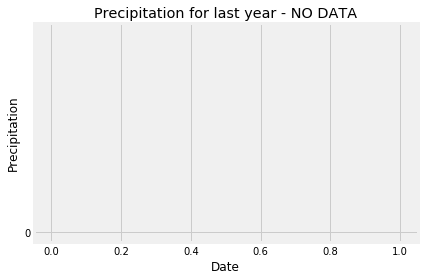

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# get the date range
end_date = dt.datetime.now().strftime ("%Y-%m-%d")
begin_date = (dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
plot_precipiation(session, begin_date, end_date, "Images/Precip_for_last_year_grpby_date.png",\
                  "Precipitation for last year")

Drawing plot for dates from 2016-08-23 to 2017-08-23 into file name "Images/Precip_for_latest_year_grpby_date.png"


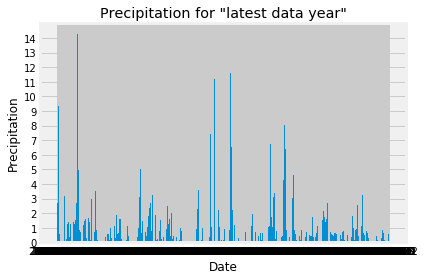

(0, 7)

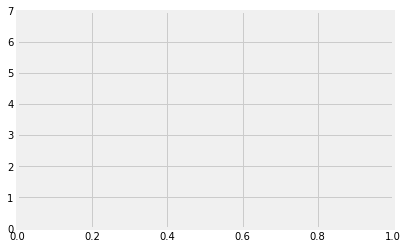

In [125]:
# Calculate the date 1 year ago from the last data point in the database
# get the date range
end_date = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date == func.max(Measurement.date).select()).first()[0]
begin_date = (dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
plot_precipiation(session, begin_date, end_date, "Images/Precip_for_latest_year_grpby_date.png", 'Precipitation for "latest data year"')

In [37]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.id,  Measurement.date, func.sum(Measurement.prcp),\
                         Measurement.tobs, Station.station, Station.name, Station.latitude, Station.longitude,\
                         Station.elevation).filter(Measurement.station == Station.station).group_by(Measurement.date).all()
df = pd.DataFrame(results, columns=["id", "date", "prcp", "tobs", "station", "name", "latitude", "longitude", "elevation"])
# df = df.dropna(how='any') # remove rows with bad data
df.head(5)

,id,date,prcp,tobs,station,name,latitude,longitude,elevation
0,1,2010-01-01,1.06,65.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,2010-01-02,0.02,63.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,2010-01-03,0.00,74.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,2010-01-04,0.01,76.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,2729,2010-01-05,0.03,76.0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df.set_index('date', inplace=True)
df.head(5)

,id,prcp,tobs,station,name,latitude,longitude,elevation
date,,,,,,,,
2010-01-01,1,1.06,65.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-02,2,0.02,63.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-03,3,0.00,74.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-04,4,0.01,76.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-05,2729,0.03,76.0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [47]:
# Sort the dataframe by date
df.sort_values(by=['date'], inplace=True)
df.head(5)

,id,prcp,tobs,station,name,latitude,longitude,elevation
date,,,,,,,,
2010-01-01,1,1.06,65.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-02,2,0.02,63.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-03,3,0.00,74.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-04,4,0.01,76.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-05,2729,0.03,76.0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [ ]:
counts = df['Drug Regimen'].value_counts()

In [ ]:
# Use Pandas Plotting with Matplotlib to plot the data

counts = study_data_complete['Drug Regimen'].value_counts()
plt.bar(counts.index.values,counts.values)
plt.xlabel("Drug Regimen")
plt.xticks(rotation=90)
plt.ylabel("Number of Data Points")
plt.show()


![precipitation](Images/precipitation.png)

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df = df["prcp"]
precip_df.describe()

count    2792.000000
mean        1.041594
std         2.224333
min         0.000000
25%         0.060000
50%         0.380000
75%         1.130000
max        37.410000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [143]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(type(stations))
stations

<class 'list'>


[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [146]:
# Design a query to show how many stations are available in this dataset?
results = session.query(Measurement.id, Measurement.date, Measurement.prcp, Measurement.tobs, Measurement.station).group_by(Measurement.station).all()
df = pd.DataFrame(results, columns=["id", "date", "prcp", "tobs", "station"])
# df = df.dropna(how='any') # remove rows with bad data
df.head(10)

,id,date,prcp,tobs,station
0,1,2010-01-01,0.08,65.0,USC00519397
1,2,2010-01-02,0.00,63.0,USC00519397
2,3,2010-01-03,0.00,74.0,USC00519397
3,4,2010-01-04,0.00,76.0,USC00519397
4,2729,2010-01-05,0.00,76.0,USC00513117
5,5,2010-01-06,NaN,73.0,USC00519397
6,6,2010-01-07,0.06,70.0,USC00519397
7,7,2010-01-08,0.00,64.0,USC00519397
8,8,2010-01-09,0.00,68.0,USC00519397
9,9,2010-01-10,0.00,73.0,USC00519397


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations_df = df.groupby('station').count()
active_stations_df.sort_values(by=['id'], inplace=True)
print("Size of data:", active_stations_df.shape)
active_stations_df.head()

Size of data: (4, 7)


,id,prcp,tobs,name,latitude,longitude,elevation
station,,,,,,,
USC00519523,1,1,1,1,1,1,1
USC00514830,2,2,2,2,2,2,2
USC00513117,65,65,65,65,65,65,65
USC00519397,2724,2724,2724,2724,2724,2724,2724


In [110]:
# get most active station id - method 1
last_row = active_stations_df.iloc[[-1], 1:1]
last_row.reset_index(inplace=True)
station_id_most_active1 = last_row.iat[0, 0]
station_id_most_active1

'USC00519397'

In [111]:
# get most active station id - method 2
station_id_most_active2 = active_stations_df.index[-1]
station_id_most_active2

'USC00519397'

In [135]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = df.loc[df["station"] == station_id_most_active1]
active_station_stats = most_active_station.describe()
# calculate the lowest temperature
lowest_temp = active_station_stats.iat[3, 2]
# highest temperature recorded
higest_temp = active_station_stats.iat[7, 2]
# average temperature
avg_temp = round(active_station_stats.iat[1, 2],1)

print("Temperatues Lowest: ", lowest_temp, ", Highest: ", higest_temp, ", Average: ", avg_temp)

Temperatues Lowest:  56.0 , Highest:  87.0 , Average:  74.6


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
